In [7]:
### Import libraries

import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt

In [295]:
def get_edge_weight(i_node, j_node):
    """
    Compute the weight of an edge between i and j nodes.

    Args:
        i_node (networkX node): i node.
        j_node (networkX node): j node.

    Returns:
        weight (float): The weight between nodes.

    Raises:
        TypeError: if there are not an intersection
    """
    neighs_i = set(i_node.neighbors())  # Set of neighbors of i
    neighs_j = set(j_node.neighbors())  # Set of neighbors of j

    # Calculate intersection between two previous sets
    insersection_neighbors = neighs_i.intersection(neighs_j)

    weight = (len(insersection_neighbors)*len(insersection_neighbors)
              ) / (len(neighs_i)*len(neighs_j))

    return weight

def bipartite_projection(biparte_network, node_type=0):
    """
    Generate a monopartite network from bipartite network.

    Parameters:
        bipartite_network (igraph Graph): The bipartie network.
        node_type (int): The set of nodes of the monopartite network.

    Returns:
        Graph (iGraph): The monopartite (projected) network.

    Raises:
        Some
    """

    # Check if the bipartite network is a bipartite network:
    # if not biparte_network.is_bipartite():
    #     raise TypeError("The ARBN is not bipartite")

    # networkX object (more easy to buil)
    g = nx.Graph()

    # All opposite node set
    opposite_nodes = biparte_network.vs.select(type=1)

    # Check for every node the same type
    for X_node in opposite_nodes:
        # Select all neighbors of the X_node
        neighbordhood = X_node.neighbors()

        for Y_node_i in neighbordhood:
            for Y_node_j in neighbordhood:
                # Ceck if both nodes are the same
                if Y_node_i['name'] != Y_node_j['name']:
                    # If there is no an edge generate
                    if not g.has_edge(Y_node_i['name'], Y_node_j['name']):
                        weight_ = get_edge_weight(Y_node_i, Y_node_j)
                        # print("Peso: ", Y_node_i['name'], "-", Y_node_j['name'], " => ", weight_)
                        g.add_edge(Y_node_i["name"], Y_node_j["name"],
                                   weight=weight_)

    # Convert from networkX graph to igraph graph
    g = ig.Graph.from_networkx(g)
    g.vs["name"] = g.vs["_nx_name"]
    del g.vs["_nx_name"]

    for u_nodes in g.vs:
        rsrcs = biparte_network.vs.find(name=u_nodes["name"]).neighbors()
        rsrcs = [r_node["name"] for r_node in rsrcs]
        u_nodes["rsrcs"] = rsrcs

    print("User Network builded!")
    print(g.summary())
    return g

In [294]:
def get_edge_weight_2(i_node, j_node, bi_graph):
    """
    Compute the weight of an edge between i and j nodes.

    Args:
        i_node (networkX node): i node.
        j_node (networkX node): j node.

    Returns:
        weight (float): The weight between nodes.

    Raises:
        TypeError: if there are not an intersection
    """
    common_neighbors = set(i_node.neighbors()).intersection(j_node.neighbors())

    if not common_neighbors:
        raise ValueError("There are no common neighbors.")

    # Calculate intersection between two previous sets
    weighted_sum = sum(bi_graph[i_node,neighbor] for neighbor in common_neighbors)
    weighted_sum += sum(bi_graph[j_node,neighbor] for neighbor in common_neighbors)
    
    i_rank = sum(bi_graph[i_node, target] for target in i_node.neighbors())

    j_rank = sum(bi_graph[j_node, target] for target in j_node.neighbors())

    weight = (weighted_sum*weighted_sum) / (i_rank*j_rank)

    return weight

def bipartite_projection_2(biparte_network, node_type=0):
    """
    Generate a monopartite network from bipartite network.

    Parameters:
        bipartite_network (igraph Graph): The bipartie network.
        node_type (int): The set of nodes of the monopartite network.

    Returns:
        Graph (iGraph): The monopartite (projected) network.

    Raises:
        Some
    """

    # Check if the bipartite network is a bipartite network:
    # if not biparte_network.is_bipartite():
    #     raise TypeError("The ARBN is not bipartite")

    # networkX object (more easy to buil)
    g = nx.Graph()

    # All opposite node set
    opposite_nodes = biparte_network.vs.select(type=1)

    # Check for every node the same type
    for X_node in opposite_nodes:
        # Select all neighbors of the X_node
        neighbordhood = X_node.neighbors()

        for Y_node_i in neighbordhood:
            for Y_node_j in neighbordhood:
                # Ceck if both nodes are the same
                if Y_node_i['name'] != Y_node_j['name']:
                    # If there is no an edge generate
                    if not g.has_edge(Y_node_i['name'], Y_node_j['name']):
                        weight_ = get_edge_weight_2(Y_node_i, Y_node_j, biparte_network)
                        # print("Peso: ", Y_node_i['name'], "-", Y_node_j['name'], " => ", weight_)
                        g.add_edge(Y_node_i["name"], Y_node_j["name"],
                                   weight=weight_)

    # Convert from networkX graph to igraph graph
    g = ig.Graph.from_networkx(g)
    g.vs["name"] = g.vs["_nx_name"]
    del g.vs["_nx_name"]

    for u_nodes in g.vs:
        rsrcs = biparte_network.vs.find(name=u_nodes["name"]).neighbors()
        rsrcs = [r_node["name"] for r_node in rsrcs]
        u_nodes["rsrcs"] = rsrcs

    print("User Network builded!")
    print(g.summary())
    return g

In [304]:
str_dataset = "AMZ"
str_distri = "Ex"

bip_network = ig.read("../data/"+str_dataset+"/binet-"+str_dataset+"-"+str_distri+".gml")
print(bip_network.summary())

IGRAPH UNWT 10717 9560 -- 
+ attr: id (v), name (v), ranking (v), type (v), weight (e)


User Network builded!
IGRAPH UNW- 4968 13558 -- 
+ attr: name (v), rsrcs (v), weight (e)
User Network builded!
IGRAPH UNW- 4968 13558 -- 
+ attr: name (v), rsrcs (v), weight (e)


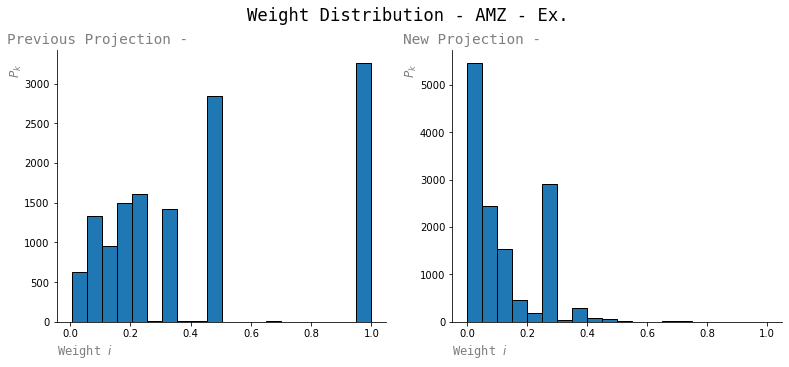

In [305]:
### Extraer primero las distribuciones de pesos

proj = bipartite_projection(bip_network)
probabilidad_acumulada = np.cumsum(proj.es["weight"]) / np.sum(proj.es["weight"])
proj2 = bipartite_projection_2(bip_network)
idk = np.array(proj2.es["weight"])/max(proj2.es["weight"])
probabilidad_acumulada2 = np.cumsum(idk) / np.sum(idk)

fig, ax = plt.subplots(1,2,figsize=(13, 5))


ax[0].spines[['right', 'top']].set_visible(False)
ax[0].hist(proj.es["weight"], bins=20, edgecolor='black')
ax[0].set_xlabel('Weight $i$', loc="left", size="large", family='monospace',
                 alpha=0.5, parse_math=True)
ax[0].set_ylabel('$P_k$', loc="top", size="large", family='monospace',
                 alpha=0.5, parse_math=True)
ax[0].yaxis.set_label_coords(-0.1,0.95)
ax[0].set_title("Previous Projection - ", loc='left', size="x-large",
                family='monospace', x=-0.15, y=1, alpha=0.5)

ax[1].spines[['right', 'top']].set_visible(False)
ax[1].hist(idk, bins=20, edgecolor='black')
ax[1].set_xlabel('Weight $i$', loc="left", size="large", family='monospace',
                 alpha=0.5, parse_math=True)
ax[1].set_ylabel('$P_k$', loc="top", size="large", family='monospace',
                 alpha=0.5, parse_math=True)
ax[1].yaxis.set_label_coords(-0.1,0.95)
ax[1].set_title("New Projection - ", loc='left', size="x-large",
                family='monospace', x=-0.15, y=1, alpha=0.5)


plt.suptitle("Weight Distribution - "+ str_dataset + " - " + str_distri + ".",
             size="xx-large", family='monospace', x=0.5, y=1)
plt.show()

In [307]:
sum_prev = 0
sum_new = 0
for i in range(10):
    sum_prev += proj.community_multilevel(weights=proj.es["weight"]).modularity
    sum_new += proj2.community_multilevel(weights=proj2.es["weight"]).modularity    
print("Prev. Mod = ", sum_prev/10)
print("New. Mod = ", sum_new/10)

Prev. Mod =  0.9671924256428805
New. Mod =  0.9731333939314636
